In [16]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install pytorch-tabnet

Looking in indexes: https://download.pytorch.org/whl/cu118


In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pytorch_tabnet.tab_model import TabNetClassifier
import matplotlib.pyplot as plt
import gc
import torch
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, classification_report

In [18]:
def preencher_valores_com_media_mediana(df):
    for col in df.columns:
        if df[col].dtype in ['float64', 'int64'] and df[col].isnull().sum() > 0:  # Verifica se a coluna é numérica e se tem nulos
            skewness = df[col].skew()  # Calcula a skewness da coluna
            if skewness >= -0.5 and skewness <= 0.5:
                # Distribuição simétrica, preenche com a média
                media = df[col].mean()
                df[col] = df[col].fillna(media)
                # print(f"Coluna '{col}' classificada como simétrica. Preenchendo nulos com a média: {media}")
            else:
                # Distribuição assimétrica, preenche com a mediana
                mediana = df[col].median()
                df[col] = df[col].fillna(mediana)
                # print(f"Coluna '{col}' classificada como assimétrica. Preenchendo nulos com a mediana: {mediana}")
    return df

In [19]:
# 1. Carregar dados de treino e teste
print("Carregando dados...")
df_train = pd.read_csv('DF_amostra_02.csv')
df_test = pd.read_csv('test.csv')

Carregando dados...


In [20]:
# 2. Preparar dados
print("\nPreparando dados...")
X = df_train.drop('y', axis=1)
y = df_train['y']

# Removendo a coluna 'y' do conjunto de teste
df_test = df_test.drop('y', axis=1)



Preparando dados...


In [21]:
# 3. Dividir em treino e teste (validação)
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [22]:
# 4. Tratar valores nulos nos conjuntos
print("\nTratando valores nulos...")
X_train = preencher_valores_com_media_mediana(X_train)
X_val = preencher_valores_com_media_mediana(X_val)
X_test = preencher_valores_com_media_mediana(df_test)



Tratando valores nulos...


In [23]:
# 5. Converter para numpy arrays
X_train = X_train.to_numpy()
X_val = X_val.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()

In [25]:
# 6. Definir parâmetros e treinar
print("\nConfigurando e treinando modelo...")
model = TabNetClassifier(
    n_d=128,
    n_a=128,
    n_steps=3,
    gamma=1.3,
    n_independent=2,
    n_shared=2,
    lambda_sparse=1e-4,
    optimizer_params={'lr': 0.02},
    optimizer_fn=torch.optim.Adam,
    verbose=1
)


Configurando e treinando modelo...


In [26]:
def test_model(pathfile):
    df_test = pd.read_csv(pathfile + '.csv')
    # Separar features e target
    X_test = df_test.drop('y', axis=1)
    y_test = df_test['y']  # Pegando os valores reais

    # Preparar dados
    X_test = preencher_valores_com_media_mediana(X_test)
    X_test = X_test.to_numpy()
    y_test = y_test.to_numpy()

    return X_test, y_test

In [27]:
# 7. Treinar modelo
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_name=['train', 'valid'],
    eval_metric=['auc', 'accuracy', 'balanced_accuracy', 'logloss'],
    max_epochs=30,
    patience=10,
    batch_size=512,
    virtual_batch_size=128
)

epoch 0  | loss: 0.63254 | train_auc: 0.72978 | train_accuracy: 0.60511 | train_balanced_accuracy: 0.60511 | train_logloss: 0.65325 | valid_auc: 0.72949 | valid_accuracy: 0.60362 | valid_balanced_accuracy: 0.60362 | valid_logloss: 0.65459 |  0:01:58s
epoch 1  | loss: 0.57087 | train_auc: 0.78814 | train_accuracy: 0.68334 | train_balanced_accuracy: 0.68334 | train_logloss: 0.59401 | valid_auc: 0.78437 | valid_accuracy: 0.67919 | valid_balanced_accuracy: 0.67919 | valid_logloss: 0.59812 |  0:04:08s
epoch 2  | loss: 0.54579 | train_auc: 0.80989 | train_accuracy: 0.73111 | train_balanced_accuracy: 0.73111 | train_logloss: 0.53923 | valid_auc: 0.8061  | valid_accuracy: 0.72735 | valid_balanced_accuracy: 0.72735 | valid_logloss: 0.54298 |  0:06:03s
epoch 3  | loss: 0.53598 | train_auc: 0.81957 | train_accuracy: 0.72487 | train_balanced_accuracy: 0.72487 | train_logloss: 0.54567 | valid_auc: 0.81412 | valid_accuracy: 0.71986 | valid_balanced_accuracy: 0.71986 | valid_logloss: 0.55334 |  0:07:

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
print("\nSalvando o modelo...")
model.save_model('TabNet_v5 128d, 512bs.zip')


Salvando o modelo...
Successfully saved model at TabNet_v5 128d, 512bs.zip.zip


'TabNet_v5 128d, 512bs.zip.zip'

In [ ]:
history = model.history
# pd.DataFrame(history).to_csv('training_history.csv', index=False)
print(history)

{'loss': [0.6325424022420688, 0.5708654802982459, 0.5457937102764853, 0.5359835447398598, 0.5214072009203606, 0.5087948416670159, 0.49837151045600536, 0.48868009275584307, 0.4801099826754243, 0.4711605358730864, 0.47069868328118764, 0.4544545906009497, 0.44954026442159106, 0.43828158018489677, 0.4302143747745841, 0.41927162481954805, 0.4123489590430701, 0.39880655685232763, 0.3914018004304834, 0.3763034538262419, 0.3645407631993293, 0.35288654826581484, 0.34257537367995183], 'lr': [0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02], 'train_auc': [0.7297760086974863, 0.7881369650332164, 0.8098919273603904, 0.8195742178920247, 0.8203999947698666, 0.8097383372290814, 0.8438756381592694, 0.8211100000616511, 0.8465733793168511, 0.7496761428884483, 0.8702151886398334, 0.8502478317688482, 0.888847976828796, 0.8530976579912594, 0.8283142512861312, 0.8800464981747004, 0.8676966780034505, 0.8914528664359733, 0

In [ ]:
history_dict = {
    'epoch': range(len(model.history['loss'])),
    'loss': model.history['loss'],
    'train_auc': model.history['train_auc'],
    'valid_auc': model.history['valid_auc']
}
history_df = pd.DataFrame(history_dict)
history_df.to_csv('TabNet_v5 128d, 512bs.csv', index=False)

In [ ]:
history_dict = {
    'epoch': range(len(model.history['loss'])),
    'loss': model.history['loss'],
    'train_auc': model.history['train_auc'],
    'valid_auc': model.history['valid_auc']
}
history_df = pd.DataFrame(history_dict)
history_df.to_csv('training_history.csv', index=False)

In [ ]:
# 8. Fazer predições no conjunto de teste
print("\nFazendo predições no conjunto de teste...")
test_predictions = model.predict_proba(X_test)


Fazendo predições no conjunto de teste...


In [ ]:
# 9. Salvar predições
print("\nSalvando predições...")
predictions_df = pd.DataFrame(test_predictions[:, 1], columns=['predictions'])
predictions_df.to_csv('predictions.csv', index=False)



Salvando predições...


In [ ]:
# 10. Imprimir algumas estatísticas das predições
print("\nEstatísticas das predições no conjunto de teste:")
print(f"Média das predições: {predictions_df['predictions'].mean():.4f}")
print(f"Desvio padrão das predições: {predictions_df['predictions'].std():.4f}")
print(f"Mínimo: {predictions_df['predictions'].min():.4f}")
print(f"Máximo: {predictions_df['predictions'].max():.4f}")


Estatísticas das predições no conjunto de teste:
Média das predições: 0.4422
Desvio padrão das predições: 0.3780
Mínimo: 0.0002
Máximo: 0.9996


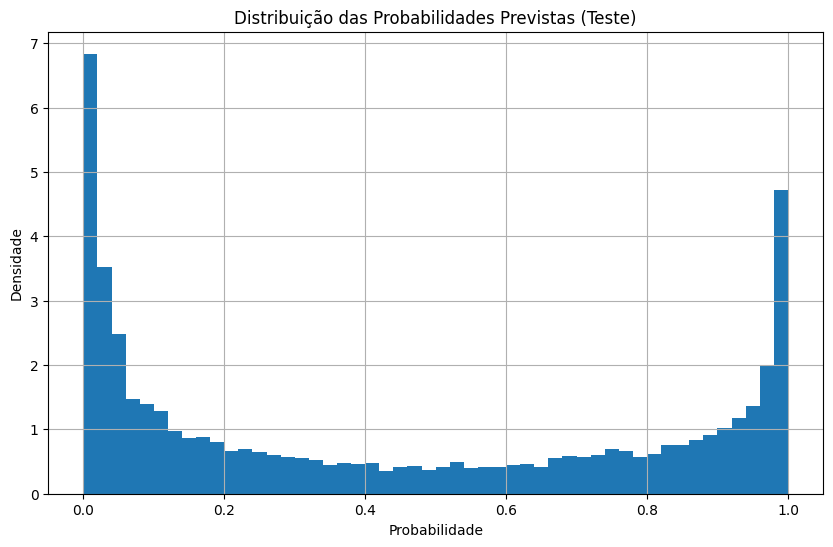

In [ ]:
# 11. Plotar distribuição das predições
plt.figure(figsize=(10, 6))
plt.hist(predictions_df['predictions'], bins=50, density=True)
plt.title('Distribuição das Probabilidades Previstas (Teste)')
plt.xlabel('Probabilidade')
plt.ylabel('Densidade')
plt.grid(True)
plt.show()

KeyError: 0

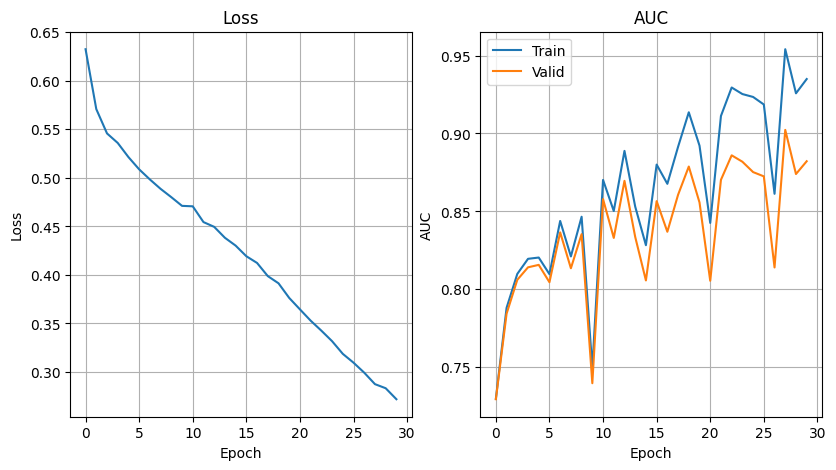

In [ ]:
# Plotar métricas ao longo do treinamento
plt.figure(figsize=(15, 5))

# Plot Loss
plt.subplot(1, 3, 1)
plt.plot(model.history['loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Plot AUC
plt.subplot(1, 3, 2)
plt.plot(model.history['train_auc'], label='Train')
plt.plot(model.history['valid_auc'], label='Valid')
plt.title('AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
X_test, y_test = test_model('DF_amostra_02_B')

# 8. Fazer predições no conjunto de teste
print("\nFazendo predições no conjunto de teste...")
test_predictions = model.predict_proba(X_test)

# # 9. Salvar predições
# print("\nSalvando predições...")
# predictions_df = pd.DataFrame(test_predictions[:, 1], columns=['predictions'])
# predictions_df.to_csv('predictions.csv', index=False)

# # 10. Imprimir algumas estatísticas das predições
# print("\nEstatísticas das predições no conjunto de teste:")
# print(f"Média das predições: {predictions_df['predictions'].mean():.4f}")
# print(f"Desvio padrão das predições: {predictions_df['predictions'].std():.4f}")
# print(f"Mínimo: {predictions_df['predictions'].min():.4f}")
# print(f"Máximo: {predictions_df['predictions'].max():.4f}")


Fazendo predições no conjunto de teste...


In [ ]:
# Calcular ROC AUC
fpr, tpr, _ = roc_curve(y_test, test_predictions[:, 1])
auc = roc_auc_score(y_test, test_predictions[:, 1])

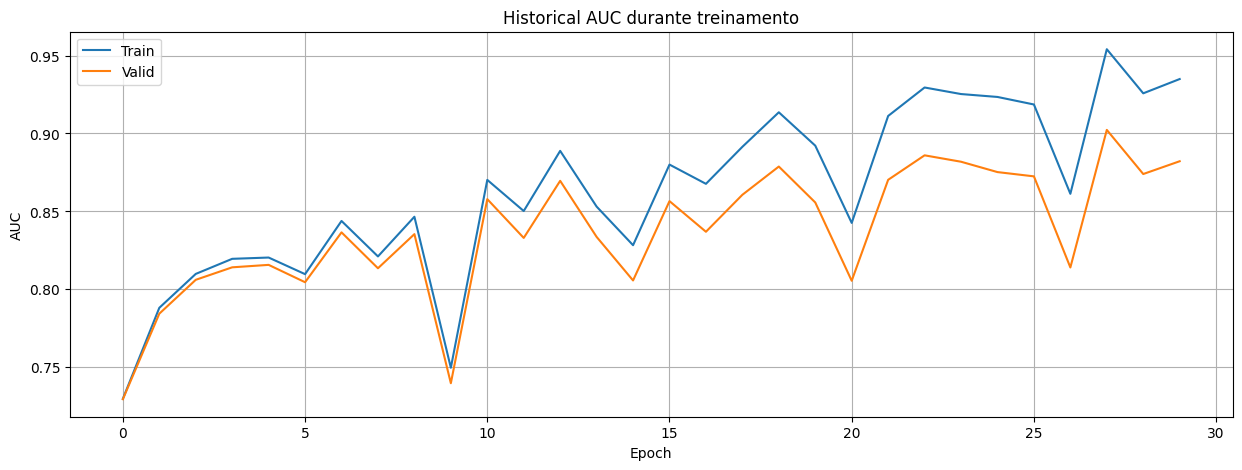

In [ ]:
# Plotar curvas
plt.figure(figsize=(15, 5))

# Plot do histórico de treino
plt.plot(model.history['train_auc'], label='Train')
plt.plot(model.history['valid_auc'], label='Valid')
plt.title('Historical AUC durante treinamento')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)

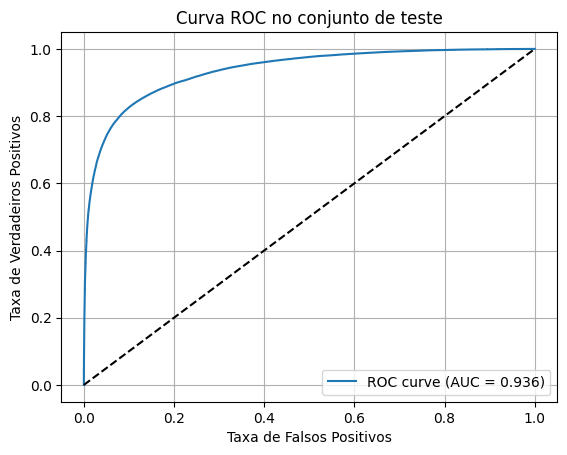

In [ ]:
# Plot da curva ROC
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')  # linha diagonal
plt.title('Curva ROC no conjunto de teste')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend()
plt.grid(True)


In [ ]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

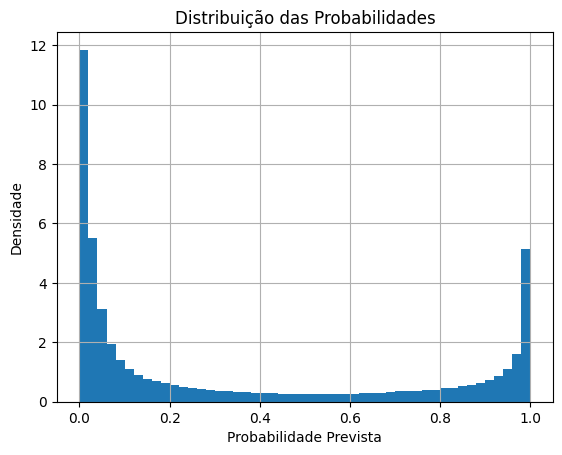

In [ ]:
# Plot da distribuição das predições
plt.hist(test_predictions[:, 1], bins=50, density=True)
plt.title('Distribuição das Probabilidades')
plt.xlabel('Probabilidade Prevista')
plt.ylabel('Densidade')
plt.grid(True)



Fazendo predições no conjunto de teste...


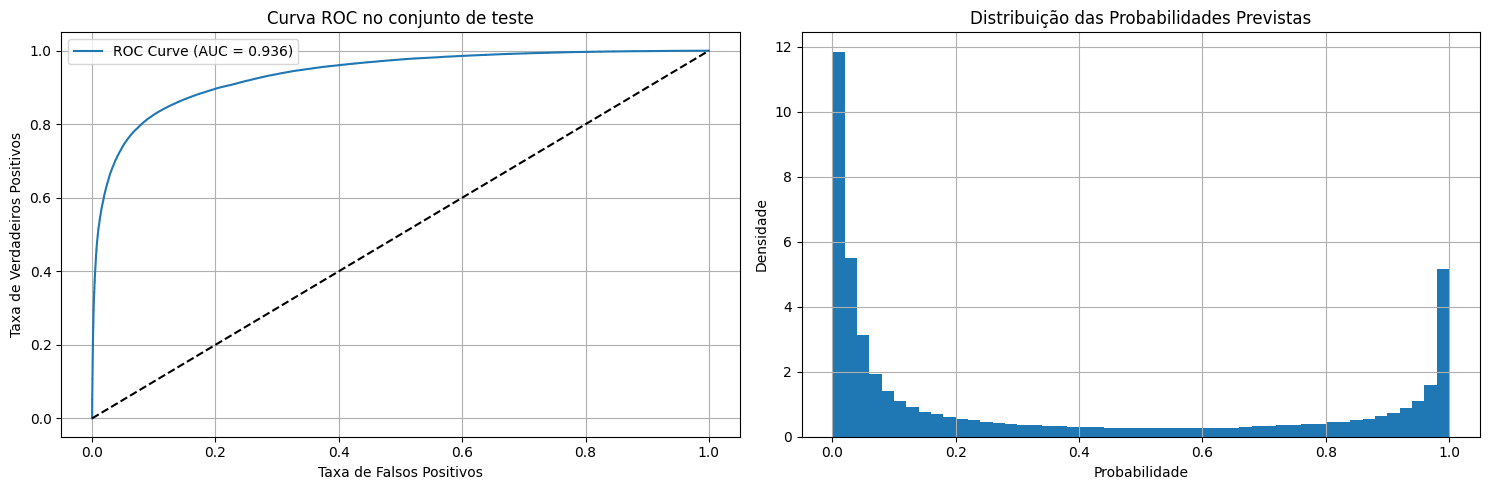


Métricas no conjunto de teste:
AUC: 0.9359


In [ ]:
def evaluate_test_results(X_test, y_test, test_predictions):
    # Fazer predições
    print("\nFazendo predições no conjunto de teste...")

    # Calcular métricas
    fpr, tpr, thresholds = roc_curve(y_test, test_predictions[:, 1])
    auc = roc_auc_score(y_test, test_predictions[:, 1])

    # Plotar resultados
    plt.figure(figsize=(15, 5))

    # Plot da curva ROC
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Linha diagonal
    plt.title('Curva ROC no conjunto de teste')
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.legend()
    plt.grid(True)

    # Plot da distribuição das probabilidades
    plt.subplot(1, 2, 2)
    plt.hist(test_predictions[:, 1], bins=50, density=True)
    plt.title('Distribuição das Probabilidades Previstas')
    plt.xlabel('Probabilidade')
    plt.ylabel('Densidade')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Imprimir métricas
    print(f"\nMétricas no conjunto de teste:")
    print(f"AUC: {auc:.4f}")

    return test_predictions, auc


# Avaliar resultados
test_predictions, test_auc = evaluate_test_results(X_test, y_test, test_predictions)

# Salvar predições
predictions_df = pd.DataFrame({
    'true_values': y_test,
    'predicted_proba': test_predictions[:, 1]
})
# predictions_df.to_csv('test_predictions.csv', index=False)

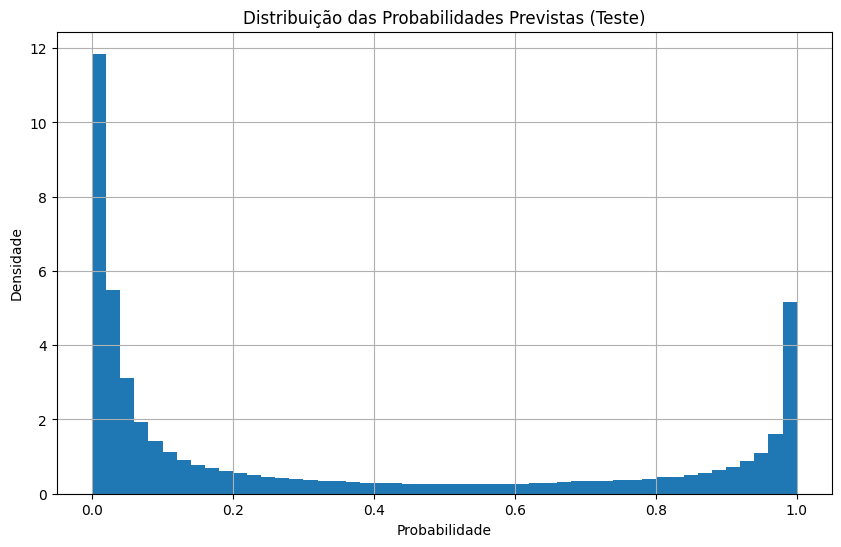

In [ ]:
# 11. Plotar distribuição das predições
plt.figure(figsize=(10, 6))
plt.hist(predictions_df['predictions'], bins=50, density=True)
plt.title('Distribuição das Probabilidades Previstas (Teste)')
plt.xlabel('Probabilidade')
plt.ylabel('Densidade')
plt.grid(True)
plt.show()

In [ ]:
prediction = model.predict(X_test)

# Calculando e mostrando a acurácia
acuracia = accuracy_score(y_test, prediction)
print(f"\nAcurácia do modelo: {acuracia:.4f}")

# Mostrando relatório detalhado de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, prediction))

# Verificando e mostrando a importância das features
importancia_features = pd.DataFrame({
    'feature': X.columns,  # Mantemos as colunas originais do DataFrame
    'importancia': model.feature_importances_
})
print("\nImportância das Features:")
print(importancia_features.sort_values('importancia', ascending=False))